# 1. Install Dependencies and Setup

In [63]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [64]:
!pip list

Package                      Version
---------------------------- -------------------
absl-py                      1.0.0
annotated-types              0.7.0
antigranular                 0.2.12
anyio                        4.0.0
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.3.0
asttokens                    2.0.5
astunparse                   1.6.3
async-lru                    2.0.4
async-timeout                4.0.2
attrs                        23.1.0
autoviz                      0.1.58
Babel                        2.13.1
backcall                     0.2.0
beautifulsoup4               4.10.0
black                        22.1.0
bleach                       4.1.0
blinker                      1.6.2
bokeh                        2.4.3
bs4                          0.0.1
cachetools                   5.0.0
certifi                      2021.10.8
cffi                         1.15.0
charset-normalizer           2.0.12
click                    

In [65]:
import tensorflow as tf
import os

In [66]:
# Avoid OOM (out of memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [67]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [68]:
import cv2
import imghdr

In [69]:
data_dir = 'data' 

In [70]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [71]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [72]:
import numpy as np
from matplotlib import pyplot as plt

In [73]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [74]:
data_iterator = data.as_numpy_iterator()

In [75]:
batch = data_iterator.next()

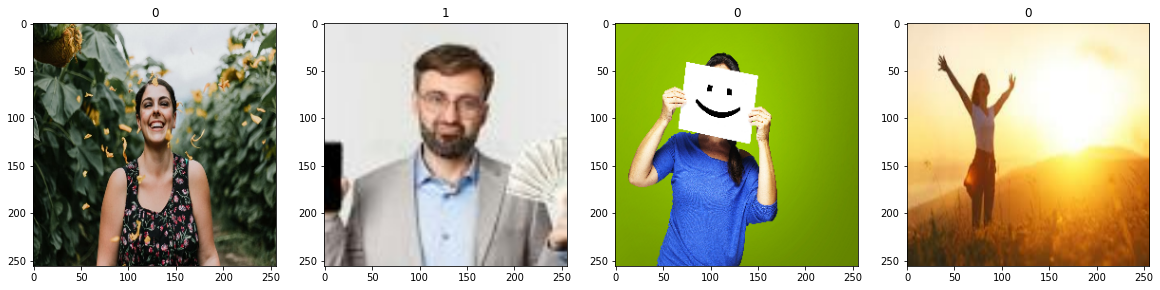

In [76]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [77]:
data = data.map(lambda x,y: (x/255, y))

In [78]:
data.as_numpy_iterator().next()

(array([[[[0.58431375, 0.5137255 , 0.35686275],
          [0.58465075, 0.5140625 , 0.35719976],
          [0.5861826 , 0.51559436, 0.35873163],
          ...,
          [0.7882353 , 0.77254903, 0.7607843 ],
          [0.7882353 , 0.77254903, 0.7607843 ],
          [0.7882353 , 0.77254903, 0.7607843 ]],
 
         [[0.58465075, 0.5140625 , 0.35719976],
          [0.5849588 , 0.51437056, 0.3575078 ],
          [0.586359  , 0.5157708 , 0.35890803],
          ...,
          [0.7865344 , 0.77084816, 0.75908345],
          [0.78627115, 0.7705849 , 0.7588202 ],
          [0.7862132 , 0.77052695, 0.75876224]],
 
         [[0.5861826 , 0.51559436, 0.35873163],
          [0.586359  , 0.5157708 , 0.35890803],
          [0.5871608 , 0.5165726 , 0.35970986],
          ...,
          [0.77880335, 0.7631171 , 0.75135237],
          [0.7773433 , 0.761657  , 0.7498923 ],
          [0.77702206, 0.7613358 , 0.7495711 ]],
 
         ...,
 
         [[0.0606924 , 0.0606924 , 0.05284926],
          [0.06102

# 5. Split Data

In [79]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [80]:
train_size

7

In [81]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [82]:
train

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [84]:
model = Sequential()

In [85]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [86]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [87]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

# 7. Train

In [88]:
logdir='logs'

In [89]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [90]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 8s 850ms/step - loss: 0.8618 - accuracy: 0.5714 - val_loss: 0.6540 - val_accuracy: 0.7969
Epoch 2/20
7/7 [==============================] - 7s 818ms/step - loss: 0.6395 - accuracy: 0.6295 - val_loss: 0.6072 - val_accuracy: 0.6875
Epoch 3/20
7/7 [==============================] - 7s 873ms/step - loss: 0.5770 - accuracy: 0.7009 - val_loss: 0.4773 - val_accuracy: 0.8438
Epoch 4/20
7/7 [==============================] - 8s 946ms/step - loss: 0.4986 - accuracy: 0.7946 - val_loss: 0.4383 - val_accuracy: 0.7656
Epoch 5/20
7/7 [==============================] - 7s 845ms/step - loss: 0.3996 - accuracy: 0.8661 - val_loss: 0.3744 - val_accuracy: 0.7656
Epoch 6/20
7/7 [==============================] - 7s 779ms/step - loss: 0.2725 - accuracy: 0.8929 - val_loss: 0.2260 - val_accuracy: 0.9062
Epoch 7/20
7/7 [==============================] - 7s 798ms/step - loss: 0.1844 - accuracy: 0.9464 - val_loss: 0.1756 - val_accuracy: 0.9688
Epoch 8/20
7/7 [====

# 8. Plot Performance

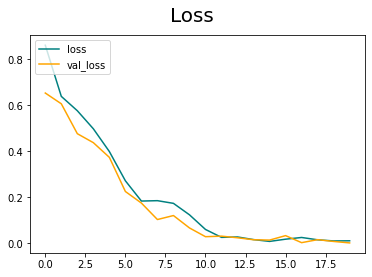

In [91]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

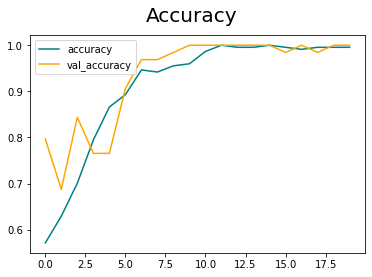

In [92]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [93]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [94]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [95]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

In [96]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [97]:
import cv2

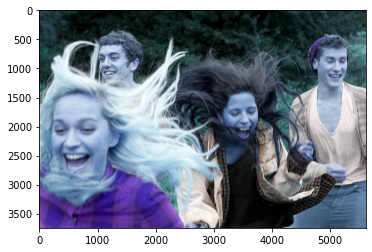

In [98]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

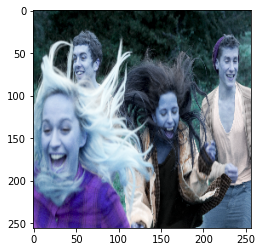

In [99]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [100]:
yhat = model.predict(np.expand_dims(resize/255, 0))

In [101]:
yhat

array([[0.02297035]], dtype=float32)

In [102]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [103]:
from tensorflow.keras.models import load_model

In [104]:
# model.save(os.path.join('models','imageclassifier.h5'))
model.save('imageclassifier.h5')

In [105]:
new_model = load_model('imageclassifier.h5')

In [106]:
new_model.predict(np.expand_dims(resize/255, 0))

array([[0.02297035]], dtype=float32)